In [31]:
import numpy as np
import pandas as pd

import string
import nltk

import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

In [32]:
spam_dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'],skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].replace(['ham', 'spam'], [0, 1])
spam_dataset

,Spam,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [33]:
print(spam_dataset['Spam'].value_counts(normalize=True))

0    0.865937
1    0.134063
Name: Spam, dtype: float64


In [34]:
def remove_puncation(text):
    cleaned = ''.join([word for word in text if word not in string.punctuation])
    return cleaned
spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(lambda x: remove_puncation(x))

In [35]:
def tokenize(text):
    # Usunięcie wielkich liter
    clean_text = text.lower()
    # Tokenizacja
    tokenized_text = nltk.word_tokenize(clean_text)
    return tokenized_text

spam_dataset['Tokenized_Text'] = spam_dataset['Cleaned_Text'].apply(lambda x: tokenize(x))

In [36]:
stopwords = nltk.corpus.stopwords.words("english")
def remove_stopwords(text):
    without_stopwords = [word for word in text if word not in stopwords]
    return without_stopwords
spam_dataset['WithoutStop_Text'] = spam_dataset['Tokenized_Text'].apply(lambda x: remove_stopwords(x))

In [37]:
stemmer = nltk.PorterStemmer()
def stemming(text):
    stemmed_words = [stemmer.stem(word) for word in text]
    return stemmed_words
spam_dataset['Stemmed_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: stemming(x))

In [38]:
lemmater = nltk.WordNetLemmatizer()
def lemmatizing(text):
    lemmatized_words = [lemmater.lemmatize(word) for word in text]
    return lemmatized_words
spam_dataset['Lemmatized_Text'] = spam_dataset['WithoutStop_Text'].apply(lambda x: lemmatizing(x))

In [39]:
X = spam_dataset['Lemmatized_Text']
y = spam_dataset['Spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [40]:
tfidf = TfidfVectorizer() 
tfidf_train = tfidf.fit_transform(X_train.apply(lambda x: ' '.join(x)))
tfidf_test = tfidf.transform(X_test.apply(lambda x: ' '.join(x)))

In [41]:
clf = RandomForestClassifier()
clf.fit(tfidf_train,y_train)
clf.score(tfidf_test,y_test)

0.9739910313901345

In [42]:
features = pd.DataFrame({'names':tfidf.get_feature_names_out(),'importances':clf.feature_importances_})
features_iportance_hd_001=features[features['importances'] <= 0.001]
features_iportance_hd_001

,names,importances
0,008704050406,4.989446e-05
1,0089my,5.476842e-05
2,0121,1.804083e-04
3,01223585236,2.094798e-04
4,01223585334,8.516358e-05
...,...,...
7813,ûªt,1.310426e-05
7814,ûªve,0.000000e+00
7815,ûï,8.036045e-08
7816,ûïharry,3.121278e-05


In [43]:
new_extends=list(features['names'])
stopwords.extend(new_extends)
X_train = X_train.apply(lambda x: remove_stopwords(x))
X_test = X_test.apply(lambda x: remove_stopwords(x))

In [44]:
tfidf_2 = TfidfVectorizer() 
tfidf_2_train = tfidf_2.fit_transform(X_train.apply(lambda x: ' '.join(x)))
tfidf_2_test = tfidf_2.transform(X_test.apply(lambda x: ' '.join(x)))
clf_2 = RandomForestClassifier()
clf_2.fit(tfidf_2_train,y_train)
clf_2.score(tfidf_2_test,y_test)

0.9130044843049328

In [45]:
tfidf = TfidfVectorizer()
params_tfidf = {'ngram_range': [(1,1),(1,2),(2,2)],
                'min_df':[0.005,0.01,0.02,0.03],
                'max_df': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
tfidf_gridsearch = GridSearchCV(tfidf,
                             params_tfidf,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)
tfidf_gridsearch.fit(X_train.apply(lambda x: ' '.join(x)),y_train)
print('\nBest hyperparameter:', tfidf_gridsearch.best_params_)
tfidf_3 = tfidf_gridsearch.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best hyperparameter: {'max_df': 0.1, 'min_df': 0.005, 'ngram_range': (1, 1)}


In [46]:
tfidf_3_train = tfidf_3.fit_transform(X_train.apply(lambda x: ' '.join(x)))
tfidf_3_test = tfidf_3.transform(X_test.apply(lambda x: ' '.join(x)))

In [47]:
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
params_rf = {'max_depth': [20,50,100,200],
             'min_samples_leaf': [1,2,3,5,10,15,20]}
rf_gridsearch = GridSearchCV(rf,
                             params_rf,
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)
rf_gridsearch.fit(tfidf_3_train,y_train)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)
clf_3 = rf_gridsearch.best_estimator_

Fitting 5 folds for each of 28 candidates, totalling 140 fits

Best hyperparameter: {'max_depth': 20, 'min_samples_leaf': 1}


In [48]:
clf_3.fit(tfidf_3_train,y_train)
clf_3.score(tfidf_3_test,y_test)

0.8798206278026905

In [49]:
print('Random Forest:                             ', clf.score(tfidf_test,y_test))
print('Random Forest - feature importance > 0.001:', clf_2.score(tfidf_2_test,y_test))
print('Random Forest - GridSearch:                ', clf_3.score(tfidf_3_test,y_test))

Random Forest:                              0.9739910313901345
Random Forest - feature importance > 0.001: 0.9130044843049328
Random Forest - GridSearch:                 0.8798206278026905


### Zadanie: metryki

In [50]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [51]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score_test','F1_score_train','AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []
def calculate_metrics(model, name, X_checked, y_checked, X_trained,y_trained):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_train= model.predict(X_trained)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba, pos_label=1)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric_test = f1_score(y_checked, predictions,average = 'weighted')
    f1_metric_train = f1_score(y_trained, predictions_train,average = 'weighted')
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1],multi_class = 'ovr')

    metrics_dataframe = metrics_dataframe.append({
                                                'Model': name,
                                                'F1_score_test': f1_metric_test,
                                                'F1_score_train': f1_metric_train, 
                                                'AUC': auc_metric},
                                                 ignore_index=True)
    return metrics_dataframe

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.99      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



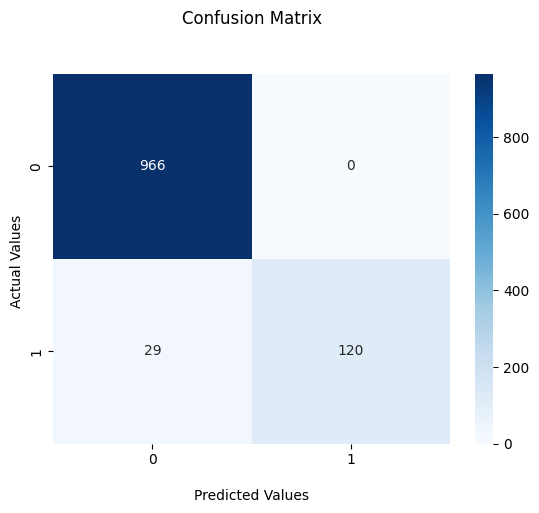

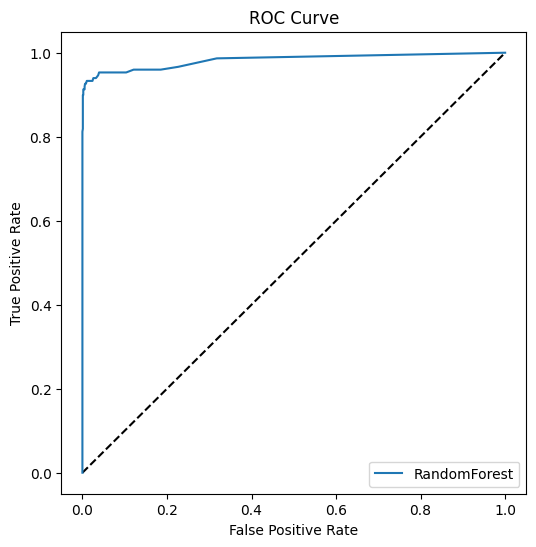

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       966
           1       1.00      0.35      0.52       149

    accuracy                           0.91      1115
   macro avg       0.95      0.67      0.73      1115
weighted avg       0.92      0.91      0.89      1115



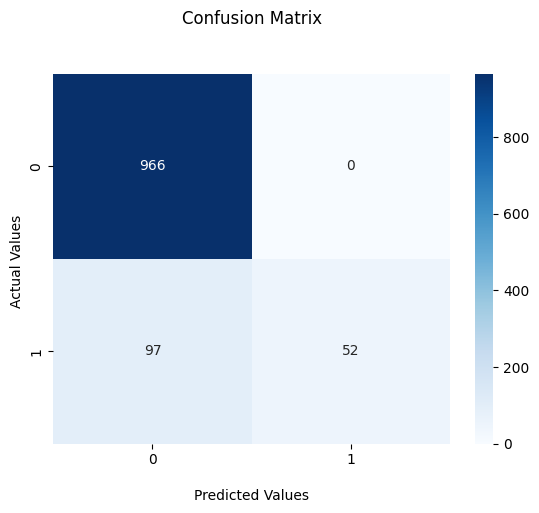

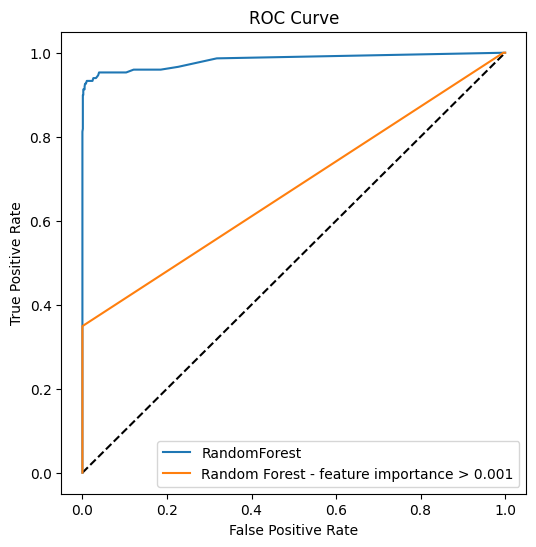

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       966
           1       1.00      0.10      0.18       149

    accuracy                           0.88      1115
   macro avg       0.94      0.55      0.56      1115
weighted avg       0.89      0.88      0.83      1115



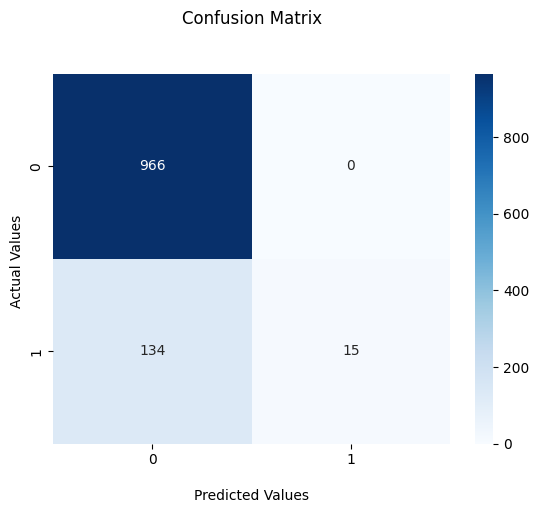

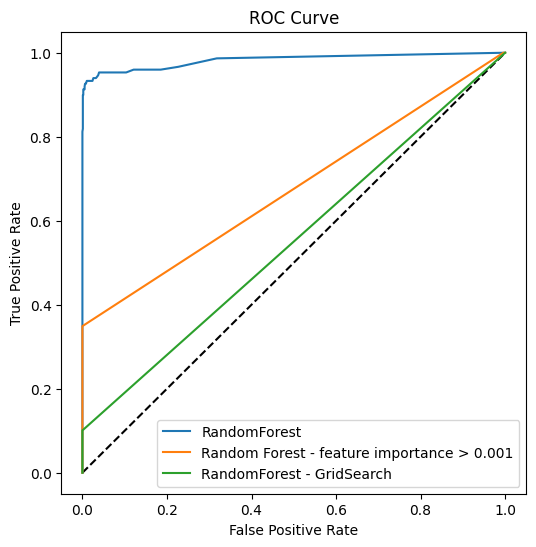

,Model,F1_score_test,F1_score_train,AUC
0,RandomForest,0.972781,1.000000,0.982631
1,Random Forest - feature importance > 0.001,0.894093,0.887058,0.675844
2,RandomForest - GridSearch,0.834620,0.826719,0.550336


In [52]:
calculate_metrics(clf, 'RandomForest', tfidf_test,y_test,tfidf_train,y_train)
calculate_metrics(clf_2, 'Random Forest - feature importance > 0.001', tfidf_2_test,y_test,tfidf_2_train,y_train)
calculate_metrics(clf_3, 'RandomForest - GridSearch', tfidf_3_test,y_test,tfidf_3_train,y_train)